In [1]:
import os
os.chdir("..")

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.models import MLP
from utils.data_module import RothfussDataModule, VoestDataModule
from tqdm import tqdm

In [12]:
#data_module = RothfussDataModule(dataset_name = "energy" ,data_path = "datasets/rothfuss_datasets/")
data_module = VoestDataModule(data_path = "datasets/voest_datasets/")
train_loader = data_module.get_train_dataloader(256)
val_loader = data_module.get_val_dataloader(256)
test_loader = data_module.get_test_dataloader(256)

/mnt/92669E5D669E4241/uncertainty_prediction/utils/data_module.py:350: RuntimeWarning: Mean of empty slice
  mean_vals = np.nanmean(self.x_total, axis=0)
/home/alexander/miniconda3/envs/uncertainty_prediction/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [13]:
mlp = MLP(data_module.x_train.shape[1], [32, 32], data_module.y_train.shape[1])

In [14]:
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

In [15]:
mean_x, std_x = torch.tensor(data_module.x_train.mean(axis=0), dtype=torch.float32), torch.tensor(data_module.x_train.std(axis=0), dtype=torch.float32)
mean_y, std_y = torch.tensor(data_module.y_train.mean(axis=0), dtype=torch.float32), torch.tensor(data_module.y_train.std(axis=0), dtype=torch.float32)

In [16]:
mean_x.dtype

torch.float32

In [17]:
val_losses = []
best_model_params = None
min_val_loss = np.inf
for epoch in tqdm(range(50)):
    for batch in train_loader:
        x, y = batch
        x = (x - mean_x) / std_x
        y = (y - mean_y) / std_y
        y_hat = mlp(x)
        loss = torch.nn.functional.mse_loss(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    eval_loss = 0
    for batch in val_loader:
        x, y = batch

        x = (x - mean_x) / std_x
        y = (y - mean_y) / std_y

        y_hat = mlp(x)
        loss = torch.nn.functional.mse_loss(y_hat, y, reduction="sum")
        eval_loss += loss.item()
    eval_loss /= len(val_loader.dataset)
    if eval_loss < min_val_loss:
        min_val_loss = loss.item()
        best_model_params = mlp.state_dict()
    val_losses.append(eval_loss)

mlp.load_state_dict(best_model_params)
test_loss = 0
test_losses = []
for batch in test_loader:
    x, y = batch

    x = (x - mean_x) / std_x
    y = (y - mean_y) / std_y
    y_hat = mlp(x)
    loss = torch.nn.functional.mse_loss(y_hat, y, reduction="none")
    test_losses.append(loss.detach().numpy())
    test_loss += loss.sum().item()
test_loss /= len(test_loader.dataset)
test_losses = np.concatenate(test_losses, axis=0)

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


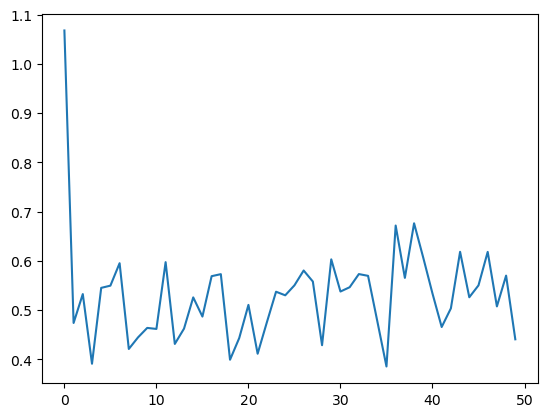

In [18]:
plt.plot(val_losses)

In [43]:
test_losses = test_losses.reshape(-1)

In [44]:
test_losses_without_outliers = np.sort(test_losses)[:-100]

In [42]:
test_losses.shape

(5359, 1)

In [32]:
test_losses_without_outliers.shape, test_losses.shape

((5349, 1), (5359, 1))

In [37]:
test_losses[test_losses > 50].shape

(9,)

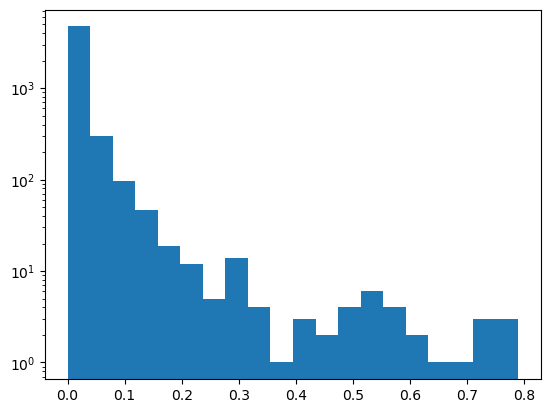

In [45]:
plt.hist(test_losses_without_outliers, bins=20)
plt.yscale("log")
plt.show()

In [20]:
test_loss

0.36830327968629445

In [ ]:
for batch in train_loader:
    x, y = batch

    x = (x - mean_x) / std_x
    y = (y - mean_y) / std_y
    y_hat = mlp(x)
    loss = torch.nn.functional.mse_loss(y_hat, y, reduction="sum")
    test_loss += loss.item(